# NLP Automatic Ticket Assignment Project


# Step 1 : Importing Dependencies

In [95]:
# !pip install chart_studio
# !pip install wordcloud
# !pip install ftfy
# !pip install lightgbm
# !pip install sklearn
# Standard Library
import pandas as pd
import numpy as np

from ftfy import *
import nltk

from utils.visualization import *
from utils.datapreprocessing import *

import missingno as msno
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns 

# For Translation
from googletrans import Translator
from langdetect import detect

# Step 2. Importing Data and performing basic EDA

In [157]:
filename= "dataset/input_final.xlsx"
df = pd.read_excel(filename, lines=True)

In [158]:
df.head(5)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details. (employee# & manager n...,spxjnwir pjlcoqds,GRP_0
1,outlook,\rreceived from: hmjdrvpb.komuaywn@gmail.com\r...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\rreceived from: eylqgodm.ybqkwiam@gmail.com\r...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [159]:
df.count()

Short description    8500
Description          8500
Caller               8500
Assignment group     8500
dtype: int64

In [99]:
# Convert datatype to string
# df = df.applymap(str)
# df.count()

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8500 non-null   object
 1   Description        8500 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


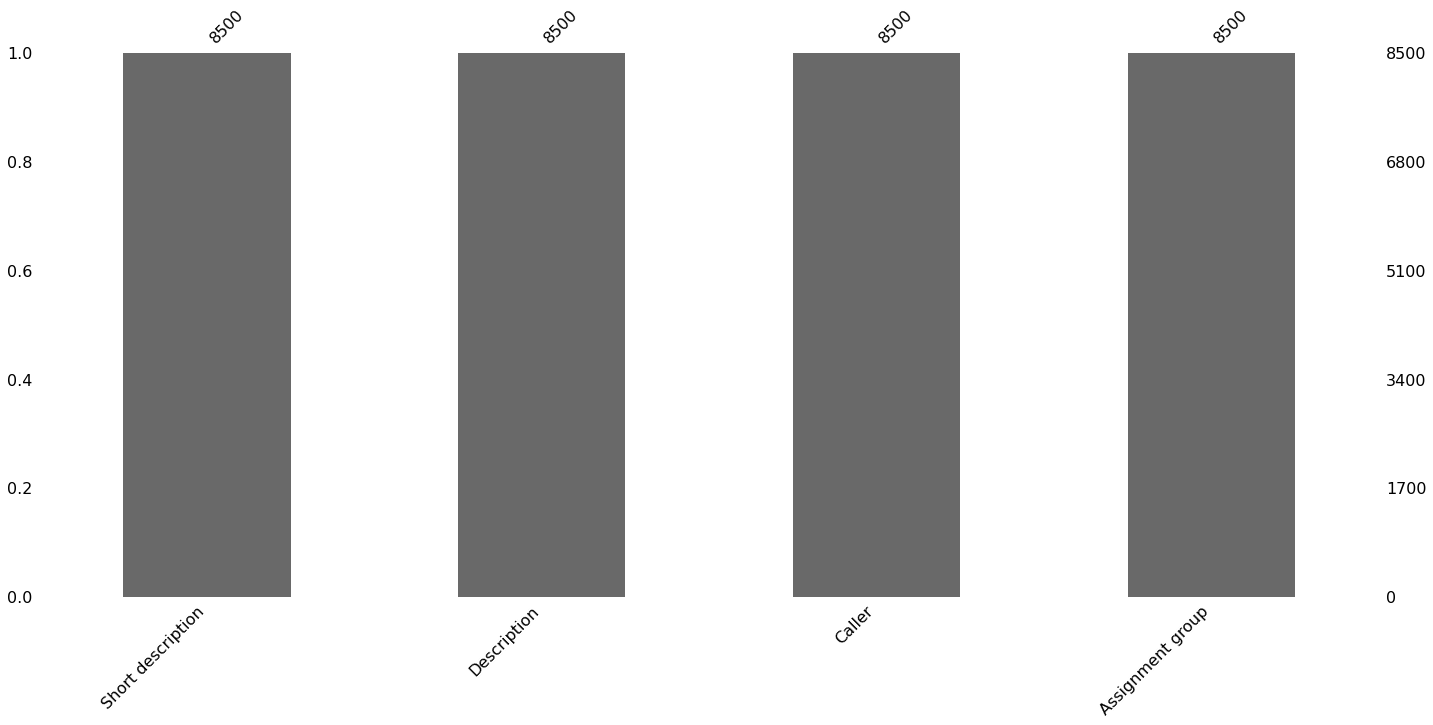

In [161]:
msno.bar(df)

## NOTE : There are 8 NaN Values in 'Short description' Feature, and 1 NaN value in 'Description' Feature.

In [162]:
df['Assignment group'].value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_67       1
GRP_70       1
GRP_73       1
GRP_61       1
GRP_35       1
Name: Assignment group, Length: 74, dtype: int64

## NOTE : There are 74 Dependent/Target classes which are required to be predicted by our Model

# Step 3 : Finding and Treating Missing Values using Rake

## 3(a). Finding NaN Values in 'Short Description' and 'Description'

In [163]:
# For Short Description
df[df['Short description'].isnull()][['Short description', 'Description']]

,Short description,Description


In [164]:
# For Description
df[df['Description'].isnull()][['Short description', 'Description']]

,Short description,Description


## 3(b). Importing and implementing RAKE(Rapid Automatic Keyword Extraction algorithm) for extracting Key phrases
---------------
* Rake extract Key phrases in a body of text by analyzing the frequency of word appearance and its co-occurance with other words in the text. 

* We will group rows of simillar Key phrases and fill missing NaN values from its simillar rows

In [165]:
r = Rake()

In [166]:
# Imputing NaN values in 'Short description' based upon corresponding 'Description' values from other simillar rows in df
df.at[2604, 'Short description'] = 'NaN'
df.at[3383, 'Short description'] = 'NaN'
df.at[3906, 'Short description'] = 'NaN'
df.at[3910, 'Short description'] = 'NaN'
df.at[3915, 'Short description'] = 'NaN'
df.at[3921, 'Short description'] = 'NaN'
df.at[3924, 'Short description'] = 'NaN'
df.at[4341, 'Short description'] = 'NaN'

# Imputing NaN values in 'Description' based upon corresponding 'Description' values from other simillar rows in df
df.at[4395, 'Description'] = 'NaN'

### Implimenting and Extracting Key Phrases in 'Description' and 'Short description'
-----------

In [167]:
df['Raked Short description'] = df['Short description'].apply(rake_implement)
df['Raked Description'] = df['Description'].apply(rake_implement)

### Key Phrases(od Description) for rows with missing Short description values
------

In [168]:
for i in df[df['Short description'] == 'NaN']['Raked Description']:
    print(i, "\n")

['kindly resolve yhe issue', 'urgent basis', 'com hi', 'working', 'rezuibdt', 'received', 'ohdrnswl', 'link', 'gmail', 'best'] 

['user system using teamviewer', 'user login', 'issue resolved', 'portal', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['microsoft internet explorer email', 'happen please help aerp', 'com customer number', 'wvqgbdhm fwchqjor language', 'te

### Corresponding 'Description values' for NaN 'Short description' rows

In [170]:
for ind in [2604, 3383, 3906, 3910, 3915, 3921, 3924, 4341]:
    print("---"*3, "Row Id ", ind, "---"*3)
    print(df.iloc[ind, 1], "\n")

--------- Row Id  2604 ---------
best 

--------- Row Id  3383 ---------
 -issue resolved. 

--------- Row Id  3906 ---------
 -issue resolved. 

--------- Row Id  3910 ---------
 -issue resolved. 

--------- Row Id  3915 ---------
 -issue resolved. 

--------- Row Id  3921 ---------
 -issue resolved. 

--------- Row Id  3924 ---------
name:wvqgbdhm fwchqjor language: browser:microsoft internet explorer email:wvqgbdhm.fwchqjor@gmail.com customer number: telephone:-not available summary:can't get into vpn - need to be on at 4:30 est and it wont' happen please help aerp! 

--------- Row Id  4341 ---------
[cid:image001.png@01d20f2e.751db880] 



### Corresponding 'Short description values' for NaN 'Description' rows

In [171]:
print("---"*3, "Row Id 4395", "---"*3)
print(df.iloc[4395, 0], "\n")

--------- Row Id 4395 ---------
i am locked out of skype 



## 3(b). Replacing NaN Values in 'Short Description' and 'Description' with simillar values from other rows

In [172]:
# Imputing NaN values in 'Short description' based upon corresponding 'Description' values from other simillar rows in df
df.at[2604, 'Short description'] = 'link not working'
df.at[3383, 'Short description'] = 'login issue'
df.at[3906, 'Short description'] = 'vpn login issue'
df.at[3910, 'Short description'] = 'vpn login issue'
df.at[3915, 'Short description'] = 'vpn login issue'
df.at[3921, 'Short description'] = 'vpn login issue'
df.at[3924, 'Short description'] = 'vpn login issue'
df.at[4341, 'Short description'] = 'login failure erp'

# Imputing NaN values in 'Description' based upon corresponding 'Description' values from other simillar rows in df
df.at[4395, 'Description'] = 'i am locked out of skype'

print("Succesfully replaced all NaN values in NaN Values in 'Short Description' and 'Description' feature.")

Succesfully replaced all NaN values in NaN Values in 'Short Description' and 'Description' feature.


In [173]:
df.count().T

Short description          8500
Description                8500
Caller                     8500
Assignment group           8500
Raked Short description    8500
Raked Description          8500
dtype: int64

## NOTE : We can verify that there are no more missing values in any of the features.

# Step 4 : Data Cleaning : Fixing Garbled Text/ Mojibake/Replacing Contractions and Lemmitization
------------------
### The most interesting kind of brokenness that ftfy will fix is when someone has encoded Unicode with one standard and decoded it with a different one. This often shows up as characters that turn into nonsense sequences (called “mojibake”)

## 5(a). Garbled Text/ Mojibake

In [174]:

# Before cleaning Garbled Text/Mojibakes with ftfy
df['Description'][164]

'  Received from: abcdri@company.com windy shi will recall the message "ticket_no1564867 -- comments added".   This information is for the sole use of designated recipients and may contain content licensed, confidential and prohibited under applicable law. Anyone other than the designated recipient is prohibited from disseminating, distributing or copying this information. If you receive this message by mistake, please notify the sender and delete it. (select the sleop link to view the disclaimer in an alternate language.'

In [175]:
### Applying ftfy.fix_text 
df['Short description'] = df['Short description'].apply(fix_text)
df['Description'] = df['Description'].apply(fix_text)
print("'Short description' and 'Description' Raking is complete.")

'Short description' and 'Description' Raking is complete.


In [176]:
df['Description'][164]

'  Received from: abcdri@company.com windy shi will recall the message "ticket_no1564867 -- comments added".   This information is for the sole use of designated recipients and may contain content licensed, confidential and prohibited under applicable law. Anyone other than the designated recipient is prohibited from disseminating, distributing or copying this information. If you receive this message by mistake, please notify the sender and delete it. (select the sleop link to view the disclaimer in an alternate language.'

## 5(b). Applying Lemmitization & Stemming and Replacing Contractions

In [177]:
for short_des in df['Short description']:
    short_des = clean_text(short_des)
print("'Short description' cleaning is complete.")

'Short description' cleaning is complete.


In [178]:
for des in df['Description']:
    des = clean_text(des)
print("'Description' Cleaning is complete.")

'Description' Cleaning is complete.


In [179]:
# Clean dataset cloumn Complete_Description

#cleanDataset(df, 'Short description', getRegexList())
#cleanDataset(df, 'Description', getRegexList())
#cleanDataset(df, 'Complete_Description', getRegexList())

# Performing a Regex_clean is causing many data to be dropped. HTML Characters/ Non standard syntax and vocabulary characters or words Later

### Checking Data after ftfy/Contraction replacement and Lemmitization

In [180]:
# After cleaning Garbled Text/Mojibakes with ftfy.fix_text
df['Description'][164]

'  Received from: abcdri@company.com windy shi will recall the message "ticket_no1564867 -- comments added".   This information is for the sole use of designated recipients and may contain content licensed, confidential and prohibited under applicable law. Anyone other than the designated recipient is prohibited from disseminating, distributing or copying this information. If you receive this message by mistake, please notify the sender and delete it. (select the sleop link to view the disclaimer in an alternate language.'

In [181]:
df['Description'].head(20)

0     -verified user details. (employee# & manager n...
1     \nreceived from: hmjdrvpb.komuaywn@gmail.com\n...
2     \nreceived from: eylqgodm.ybqkwiam@gmail.com\n...
3                         unable to access hr_tool page
4                                           skype error
5        unable to log in to engineering tool and skype
6     event: critical:HostName_221.company.com the v...
7     ticket_no1550391- employment status - new non-...
8                  unable to disable add ins on outlook
9                       ticket update on inplant_874773
10    engineering tool says not connected and unable...
11              hr_tool site not loading page correctly
12    unable to login to hr_tool to sgxqsuojr xwbeso...
13                     user wants to reset the password
14                              unable to open payslips
15                      ticket update on inplant_874743
16      received from: xyz@company.com  hi,  i am un...
17        when undocking pc , screen will not co

## NOTE : We can see that apart from English there are many non-english data points. The objective of the next step is to treat the non English language objects in df.(yet to be done)

## NOTE : We can see many non english noise in data, but we will do a second stage text filtering after translation is done, because many of the non english data will be dropped after being mistakened as noise. 

# Step 5 : Translation

In [121]:
# Inputting Path
filename= "dataset/translated_input_data.csv"

# Importing CSV as df
vaishakh_df = pd.read_csv(filename)

#Renaming Columns
vaishakh_df.columns = ['Short description', 'Description', 'Caller', 'Assignment group', 'Iso_Description', 'Language_Description', 'Translated_Description', 'Iso_Short description', 'Language_Short description', 'Translated_Short description']

In [122]:
vaishakh_df.head()

,Short description,Description,Caller,Assignment group,Iso_Description,Language_Description,Translated_Description,Iso_Short description,Language_Short description,Translated_Short description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,en,English,-verified user details.(employee# & manager na...,en,English,login issue
1,outlook,received from: hmjdrvpb.komuaywn@gmail.com ...,hmjdrvpb komuaywn,GRP_0,en,English,received from: hmjdrvpb.komuaywn@gmail.com ...,en,English,outlook
2,cant log in to vpn,received from: eylqgodm.ybqkwiam@gmail.com ...,eylqgodm ybqkwiam,GRP_0,en,English,received from: eylqgodm.ybqkwiam@gmail.com ...,en,English,cant log in to vpn
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,en,English,unable to access hr_tool page,en,English,unable to access hr_tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,ja,Japanese,skype error,ja,Japanese,skype error


In [123]:
vaishakh_df.head(5)

,Short description,Description,Caller,Assignment group,Iso_Description,Language_Description,Translated_Description,Iso_Short description,Language_Short description,Translated_Short description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,en,English,-verified user details.(employee# & manager na...,en,English,login issue
1,outlook,received from: hmjdrvpb.komuaywn@gmail.com ...,hmjdrvpb komuaywn,GRP_0,en,English,received from: hmjdrvpb.komuaywn@gmail.com ...,en,English,outlook
2,cant log in to vpn,received from: eylqgodm.ybqkwiam@gmail.com ...,eylqgodm ybqkwiam,GRP_0,en,English,received from: eylqgodm.ybqkwiam@gmail.com ...,en,English,cant log in to vpn
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,en,English,unable to access hr_tool page,en,English,unable to access hr_tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,ja,Japanese,skype error,ja,Japanese,skype error


In [124]:
vaishakh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Short description             8492 non-null   object
 1   Description                   8499 non-null   object
 2   Caller                        8500 non-null   object
 3   Assignment group              8500 non-null   object
 4   Iso_Description               8500 non-null   object
 5   Language_Description          8500 non-null   object
 6   Translated_Description        8499 non-null   object
 7   Iso_Short description         8500 non-null   object
 8   Language_Short description    8500 non-null   object
 9   Translated_Short description  8492 non-null   object
dtypes: object(10)
memory usage: 664.2+ KB


In [182]:
translated_df = pd.concat([df, vaishakh_df.drop(['Short description', 'Description', 'Caller', 'Assignment group'], axis=1)], axis=1)

In [183]:
translated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Short description             8500 non-null   object
 1   Description                   8500 non-null   object
 2   Caller                        8500 non-null   object
 3   Assignment group              8500 non-null   object
 4   Raked Short description       8500 non-null   object
 5   Raked Description             8500 non-null   object
 6   Iso_Description               8500 non-null   object
 7   Language_Description          8500 non-null   object
 8   Translated_Description        8499 non-null   object
 9   Iso_Short description         8500 non-null   object
 10  Language_Short description    8500 non-null   object
 11  Translated_Short description  8492 non-null   object
dtypes: object(12)
memory usage: 797.0+ KB


In [184]:
translated_df.head(5)

,Short description,Description,Caller,Assignment group,Raked Short description,Raked Description,Iso_Description,Language_Description,Translated_Description,Iso_Short description,Language_Short description,Translated_Short description
0,login issue,-verified user details. (employee# & manager n...,spxjnwir pjlcoqds,GRP_0,[login issue],"[verified user details, user name, manager nam...",en,English,-verified user details.(employee# & manager na...,en,English,login issue
1,outlook,\nreceived from: hmjdrvpb.komuaywn@gmail.com\n...,hmjdrvpb komuaywn,GRP_0,[outlook],"[somebody please advise, com hello team, skype...",en,English,received from: hmjdrvpb.komuaywn@gmail.com ...,en,English,outlook
2,cant log in to vpn,\nreceived from: eylqgodm.ybqkwiam@gmail.com\n...,eylqgodm ybqkwiam,GRP_0,"[cant log, vpn]","[vpn best, com hi, cannot log, ybqkwiam, recei...",en,English,received from: eylqgodm.ybqkwiam@gmail.com ...,en,English,cant log in to vpn
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,"[access hr_tool page, unable]","[access hr_tool page, unable]",en,English,unable to access hr_tool page,en,English,unable to access hr_tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,[skype error],[skype error],ja,Japanese,skype error,ja,Japanese,skype error


## 5(a). Detecting and translating the language in "Short_description" features

In [185]:
#df['Translated Short description'] = df['Short description']

In [186]:
'''
for i in range(0,df.shape[0]):
    try:
        Short_description_language = detect(str(df['Short description'][i]))
        if detect(str(df['Short description'][i])) != 'en':
            df['Translated Short description'][i] = Translator().translate(str(df['Short description'][i]),
                                                                            src= Short_description_language,
                                                                            dest='en').text
        else:
            df['Translated Short description'][i] = str(df['Short description'][i])
    except:
        print("This row throws and error:", i)
        df['Translated Short description'][i] = str(df['Short description'][i])
'''

'\nfor i in range(0,df.shape[0]):\n    try:\n        Short_description_language = detect(str(df[\'Short description\'][i]))\n        if detect(str(df[\'Short description\'][i])) != \'en\':\n            df[\'Translated Short description\'][i] = Translator().translate(str(df[\'Short description\'][i]),\n                                                                            src= Short_description_language,\n                                                                            dest=\'en\').text\n        else:\n            df[\'Translated Short description\'][i] = str(df[\'Short description\'][i])\n    except:\n        print("This row throws and error:", i)\n        df[\'Translated Short description\'][i] = str(df[\'Short description\'][i])\n'

In [187]:

print("German (Before Translation):", translated_df['Short description'][1622])
print('\nEnglish (After Translation): ', translated_df['Translated_Short description'][1622])

German (Before Translation): b'after I've opened outlook and clicked on an e-mail comes a blue circle that turns and I'm nothing '

English (After Translation):  after I open outlook and have an e-mail clicked is a blue circle rotates and I nothing


In [188]:
print("Chinese (Before Translation):",translated_df['Short description'][164])
print('\nEnglish (After Translation): '+translated_df['Translated_Short description'][164])

Chinese (Before Translation): Recall: ticket_no1564867 -- comments added

English (After Translation): 撤回: ticket_no1564867 -- comments added


## 5(b). Detecting and translating the language in "Description" features

In [132]:
#df['Translated Description'] = df['Description']

In [189]:
'''
for i in range(0,df.shape[0]):
    Description_lang = detect(str(df['Description'][i]))
    try:
        if Description_lang != 'en' : #de
            df['Translated Description'][i] = Translator().translate(str(df['Description'][i]),src= Description_lang, dest='en').text
            print("Current Time for Row Id ", i, "with Language ",Description_lang," is: ", current_time)
        else:
            df['Translated Description'][i] = str(df['Description'][i])
    except:
        print("This row throws and error:", i)
        df['Translated Description'][i] = str(df['Description'][i])
'''

'\nfor i in range(0,df.shape[0]):\n    Description_lang = detect(str(df[\'Description\'][i]))\n    try:\n        if Description_lang != \'en\' : #de\n            df[\'Translated Description\'][i] = Translator().translate(str(df[\'Description\'][i]),src= Description_lang, dest=\'en\').text\n            print("Current Time for Row Id ", i, "with Language ",Description_lang," is: ", current_time)\n        else:\n            df[\'Translated Description\'][i] = str(df[\'Description\'][i])\n    except:\n        print("This row throws and error:", i)\n        df[\'Translated Description\'][i] = str(df[\'Description\'][i])\n'

In [190]:


print("German (Before Translation):",translated_df['Description'][1622])
print('\nEnglish (After Translation): '+translated_df['Translated_Description'][1622])

German (Before Translation): do more. urgently ask for help. my mobile tel. nr.

English (After Translation): make more. Please urgently for help. my mobile tel. No.


In [191]:
print("Chinese (Before Translation):",translated_df['Description'][164])
print('\nEnglish (After Translation): '+translated_df['Translated_Description'][164])

Chinese (Before Translation):   Received from: abcdri@company.com windy shi will recall the message "ticket_no1564867 -- comments added".   This information is for the sole use of designated recipients and may contain content licensed, confidential and prohibited under applicable law. Anyone other than the designated recipient is prohibited from disseminating, distributing or copying this information. If you receive this message by mistake, please notify the sender and delete it. (select the sleop link to view the disclaimer in an alternate language.

English (After Translation): received from: abcdri@company.com windy shi will recall message "ticket_no1564867 - comments added". This message is for the designated recipient to use, which may contain privileged under applicable law, confidentiality and non-disclosure of content. In addition to the designated recipient, any other person is strictly prohibited dissemination, distribution or copying of this message. If you receive this mess

## 5(c). Findind and fixing missing values in translated data i.e. translated_df
---------------
-> 8 Values are missing in Tranlated_Short description <br>
-> 1 Value is missing in translated_Description <br>
-> All the values missing are in english language <br>
-> We will simply copy the corresponding original values

In [192]:
# For Translated Short Description we can see the respective row values are in english
translated_df[translated_df['Translated_Short description'].isnull()][['Short description', 'Description','Translated_Description']]

,Short description,Description,Translated_Description
2604,link not working,\nreceived from: ohdrnswl.rezuibdt@gmail.com\n...,received from: ohdrnswl.rezuibdt@gmail.com ...
3383,login issue,\n-connected to the user system using teamview...,-connected to the user system using teamviewe...
3906,vpn login issue,-user unable tologin to vpn.\n -connected to ...,-user unable tologin to vpn. -connected to th...
3910,vpn login issue,-user unable tologin to vpn.\n -connected to ...,-user unable tologin to vpn. -connected to th...
3915,vpn login issue,-user unable tologin to vpn.\n -connected to ...,-user unable tologin to vpn. -connected to th...
3921,vpn login issue,-user unable tologin to vpn.\n -connected to ...,-user unable tologin to vpn. -connected to th...
3924,vpn login issue,name:wvqgbdhm fwchqjor language: browser:micro...,name:wvqgbdhm fwchqjor language: browser:micro...
4341,login failure erp,\nreceived from: eqmuniov.ehxkcbgj@gmail.com\n...,received from: eqmuniov.ehxkcbgj@gmail.com ...


In [193]:
# For 'Translated_Description' we can see the respective row values are in english
translated_df[translated_df['Translated_Description'].isnull()][['Short description', 'Translated_Short description', 'Description']]

,Short description,Translated_Short description,Description
4395,i am locked out of skype,i am locked out of skype,i am locked out of skype


In [194]:
# Copying values from 'Short description' which are already correctly imputated
translated_df["Translated_Short description"] = translated_df["Translated_Short description"].fillna(translated_df["Short description"])
print("Succesfully filled all NaN values in 'Translated_Short description'")

Succesfully filled all NaN values in 'Translated_Short description'


In [195]:
# Copying values from 'Description' which are already correctly imputated
translated_df["Translated_Description"] = translated_df["Translated_Description"].fillna(translated_df["Description"])
print("Succesfully filled all NaN values in 'Translated_Description'")

Succesfully filled all NaN values in 'Translated_Description'


In [196]:
# Finding missing values in translated data
translated_df.isnull().sum()

Short description               0
Description                     0
Caller                          0
Assignment group                0
Raked Short description         0
Raked Description               0
Iso_Description                 0
Language_Description            0
Translated_Description          0
Iso_Short description           0
Language_Short description      0
Translated_Short description    0
dtype: int64

In [197]:
translated_df = translated_df.applymap(str)

In [202]:
translated_df.head()

,Short description,Description,Caller,Assignment group,Raked Short description,Raked Description,Iso_Description,Language_Description,Translated_Description,Iso_Short description,Language_Short description,Translated_Short description,Length of Translated_Description Before Summarization,Length of Translated_Short description Before Summarization
0,login issue,-verified user details. (employee# & manager n...,spxjnwir pjlcoqds,GRP_0,['login issue'],"['verified user details', 'user name', 'manage...",en,English,-verified user details.(employee# & manager na...,en,English,login issue,33,2
1,outlook,\nreceived from: hmjdrvpb.komuaywn@gmail.com\n...,hmjdrvpb komuaywn,GRP_0,['outlook'],"['somebody please advise', 'com hello team', '...",en,English,received from: hmjdrvpb.komuaywn@gmail.com ...,en,English,outlook,25,1
2,cant log in to vpn,\nreceived from: eylqgodm.ybqkwiam@gmail.com\n...,eylqgodm ybqkwiam,GRP_0,"['cant log', 'vpn']","['vpn best', 'com hi', 'cannot log', 'ybqkwiam...",en,English,received from: eylqgodm.ybqkwiam@gmail.com ...,en,English,cant log in to vpn,11,5
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,"['access hr_tool page', 'unable']","['access hr_tool page', 'unable']",en,English,unable to access hr_tool page,en,English,unable to access hr_tool page,5,5
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,['skype error'],['skype error'],ja,Japanese,skype error,ja,Japanese,skype error,2,2


In [212]:
from utils.datapreprocessing import *

In [213]:
def replaceEmailIds(dfColumn):
    newDF = pd.DataFrame()
    newDF['datacolumn'] = dfColumn
    for i, row in newDF.iterrows():
        #print(i)
        if pd.notna(newDF.at[i,'datacolumn']):
            if not re.findall('^[0-9]*$',str(newDF.at[i,'datacolumn'])):
                lstEmails = re.findall('\S+@\S+', newDF.at[i,'datacolumn'])
                #print(lstEmails)
                if lstEmails:
                    for email in lstEmails: 
                        newDF['datacolumn'][i] = newDF['datacolumn'][i].replace(email, "emailaddress")
                        #print(newDF['datacolumn'][i])
    return newDF['datacolumn']

In [214]:
translated_df['Translated_Short description'] = replaceEmailIds(translated_df['Translated_Short description'])
translated_df['Translated_Description'] = replaceEmailIds(translated_df['Translated_Description'])

In [267]:
df_rules = pd.read_csv("Rules\Rule_matrix.csv")

In [276]:
def applyDetRules(datadf,rulesdf,Description,ShortDescription):
    datadf['pred_group'] = np.nan
    for i, row in rulesdf.iterrows():
         #hardcoding GRP25
        for j, row in datadf.iterrows():
            if pd.notna(datadf[ShortDescription][j]):
                if (('erp' in datadf[ShortDescription][j]) and (('EU_tool' in datadf[ShortDescription][j]))):
                        datadf['pred_group'][j] = 'GRP_25'

        #Hardcoding GRP17
        for j, row in datadf.iterrows():
            if pd.notna(datadf[Description][j]):
                if (datadf[Description][j] == 'the'):
                        datadf['pred_group'][j] = 'GRP_17' 
                #Hardcoding GRP55
                if (('finance_app' in datadf[ShortDescription][j]) and ('HostName_1132' not in datadf[ShortDescription][j])):
                    datadf['pred_group'][j] = 'GRP_55'
                #Hardcoding GRP58
                if (('processor' in datadf[Description][j]) and ('engg' in datadf[Description][j])):
                    datadf['pred_group'][j] = 'GRP_58'
                    
        if rulesdf['Short Desc Rule'][i] == 'begins with' and rulesdf['Desc Rule'][i] == 'begins with' and pd.isna(rulesdf['User'][i]):
            for j, row in datadf.iterrows():
                if pd.notna(datadf[ShortDescription][j]) and pd.notna(datadf[Description][j]):
                    if ((datadf[ShortDescription][j].startswith(rulesdf['Short Dec Keyword'][i])) and (datadf[Description][j].startswith(rulesdf['Dec keyword'][i]))):
                        datadf['pred_group'][j] = rulesdf['Group'][i]
        if pd.isna(rulesdf['Short Desc Rule'][i]) and rulesdf['Desc Rule'][i] == 'begins with' and pd.notna(rulesdf['User'][i]):
            for j, row in datadf.iterrows():
                if pd.notna(datadf[Description][j]) and pd.notna(datadf['Caller'][j]):
                    if ((datadf[Description][j].startswith(rulesdf['Desc Rule'][i]) and (rulesdf['User'][i] == datadf['Caller'][j]))):
                        datadf['pred_group'][j] = rulesdf['Group'][i]
        if rulesdf['Short Desc Rule'][i] == 'contains' and pd.notna(rulesdf['User'][i]):
            for j, row in datadf.iterrows():
                if (pd.notna(datadf[ShortDescription][j]) and pd.notna(datadf['Caller'][j])):
                     if ((rulesdf['Short Dec Keyword'][i] in datadf[ShortDescription][j]) and (rulesdf['User'][i] == datadf['Caller'][j])):
                        datadf['pred_group'][j] = rulesdf['Group'][i]
        if rulesdf['Short Desc Rule'][i] == 'contains' and pd.isna(rulesdf['Desc Rule'][i]) and pd.isna(rulesdf['User'][i]):
            for j, row in datadf.iterrows():
                #print(j)
                if pd.notna(datadf[ShortDescription][j]):
                    if (rulesdf['Short Dec Keyword'][i] in datadf[ShortDescription][j]):
                        datadf['pred_group'][j] = rulesdf['Group'][i]
        if pd.isna(rulesdf['Short Desc Rule'][i]) and rulesdf['Desc Rule'][i] == 'begins with' and pd.isna(rulesdf['User'][i]):
            for j, row in datadf.iterrows():
                if pd.notna(datadf[Description][j]):
                    if (datadf[Description][j].startswith(rulesdf['Dec keyword'][i])):
                        datadf['pred_group'][j] = rulesdf['Group'][i]
        if pd.isna(rulesdf['Short Desc Rule'][i]) and rulesdf['Desc Rule'][i] == 'contains' and pd.isna(rulesdf['User'][i]):
            for j, row in datadf.iterrows():
                if pd.notna(datadf[Description][j]):
                    if (rulesdf['Dec keyword'][i] in datadf[Description][j]):
                        datadf['pred_group'][j] = rulesdf['Group'][i]
       

    return datadf

In [277]:
translated_df = applyDetRules(translated_df,df_rules,'Translated_Description','Translated_Short description')

In [278]:
#Export dataset to csv file
translated_df.to_csv(r'dataset/HarshaCharan_output.csv', index = False)

In [279]:
df2 = pd.DataFrame()
df2['Caller'] = translated_df['Caller']
df2['AssignmentGroup'] = translated_df['Assignment group']
df2['ShortDescription'] = translated_df['Translated_Short description']
df2['Description'] = translated_df['Translated_Description']
df2['PredictedGroup'] = translated_df['pred_group']

In [280]:
df3 = pd.DataFrame()

In [285]:
df3 = df2[~(df2['PredictedGroup'].isna()) & ((df2['PredictedGroup'] == df2['AssignmentGroup']))]

In [287]:
df3['PredictedGroup'].value_counts()
# 8191 rows × 5 columns
# 8184 rows × 5 columns
# 8184 rows × 5 columns

GRP_0     140
GRP_17     56
GRP_2      41
GRP_12     12
GRP_55      7
GRP_39      7
GRP_36      4
GRP_25      4
GRP_8       4
GRP_38      3
GRP_63      3
GRP_58      3
GRP_54      2
GRP_71      2
GRP_69      2
GRP_68      2
GRP_64      1
GRP_46      1
GRP_70      1
GRP_61      1
GRP_73      1
GRP_67      1
GRP_35      1
Name: PredictedGroup, dtype: int64

In [288]:
translated_df_dr = translated_df

In [289]:
translated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 18 columns):
 #   Column                                                       Non-Null Count  Dtype 
---  ------                                                       --------------  ----- 
 0   Short description                                            8500 non-null   object
 1   Description                                                  8500 non-null   object
 2   Caller                                                       8500 non-null   object
 3   Assignment group                                             8500 non-null   object
 4   Raked Short description                                      8500 non-null   object
 5   Raked Description                                            8500 non-null   object
 6   Iso_Description                                              8500 non-null   object
 7   Language_Description                                         8500 non-null   object
 8 

In [294]:
translated_df = translated_df[(translated_df['PredictedGroup'].isna())]

In [295]:
translated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8184 entries, 0 to 8499
Data columns (total 18 columns):
 #   Column                                                       Non-Null Count  Dtype 
---  ------                                                       --------------  ----- 
 0   Short description                                            8184 non-null   object
 1   Description                                                  8184 non-null   object
 2   Caller                                                       8184 non-null   object
 3   Assignment group                                             8184 non-null   object
 4   Raked Short description                                      8184 non-null   object
 5   Raked Description                                            8184 non-null   object
 6   Iso_Description                                              8184 non-null   object
 7   Language_Description                                         8184 non-null   object
 8 

# Step 6: Feature Engineering : Text Summarizing for large 'Description'/'Translated_Description' Values  
----------

## 6(a). EDA on length of Translated_Description is more than 150

In [198]:
translated_df.loc[ translated_df['Translated_Description'].apply(lambda x : len(x) > 150) ].shape

(2771, 12)

In [199]:
translated_df['Length of Translated_Description Before Summarization'] = translated_df['Translated_Description'].apply(lambda x: len(str(x).split()))

translated_df['Length of Translated_Short description Before Summarization'] = translated_df['Translated_Short description'].apply(lambda x: len(str(x).split()))

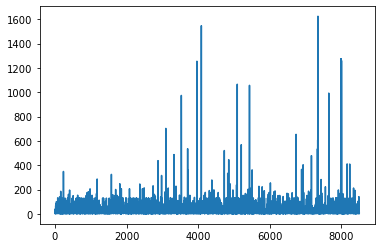

In [200]:
translated_df['Length of Translated_Description Before Summarization'].plot()

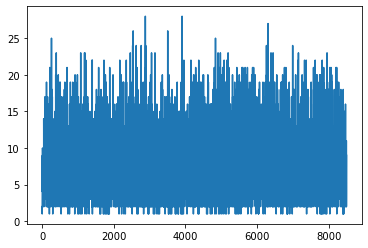

In [201]:
translated_df['Length of Translated_Short description Before Summarization'].plot()

## 6(b). Applying Text Summarization on Translated_Description with more than 150 words

### Testing Out Summarizer feature extractor function

In [146]:
str_me = '''received from: abcdri@company.com windy shi will recall message "ticket_no1564867 - comments added". This message is for the designated recipient to use, which may contain privileged under applicable law, confidentiality and non-disclosure of content. '''

str_me1 ='''  The coronavirus disease is spreading across the country at a rapid pace, but the situation is grim in Maharashtra, Delhi, Tamil Nadu, Haryana, West Bengal, Jammu and Kashmir and Uttar Pradesh.

According to Union health ministry, these states have seen a large number of Covid-19 cases in the last 10 days.

In Delhi, nearly 1,300 cases are being recorded everyday. A fortnight ago, this number was around 1,000. On Thursday, the national capital recorded 1,877 new infections.

In Tamil Nadu, the second worst-affected state after Maharashtra, the single-day spike has nearly doubled from an average 700 to more than 1,300. On Thursday, it registered a record 1,927 Covid-19 cases. There is a three-fold increase in the number of cases in Haryana, and the number has doubled in Jammu and Kashmir, according to health ministry data. There are seven states in the country which have more than 10,000 cases of coronavirus disease.

With the rising number of cases, Uttar Pradesh has now reached the fifth spot on the health ministry’s list of statewise count of Covid-19 cases. The state has registered 201 deaths till May 31. But on Thursday, the Covid-19 fatality count of Uttar Pradesh reached 321.

The nationwide Covid-19 tally neared 2.9 lakh on Thursday with a record one-day increase of nearly 10,000 cases. 
In its morning update, the Union Health Ministry said the total number of confirmed Covid-19 cases has risen to 2,86,579 after a record number of 9,996 cases were reported in 24 hours since Wednesday 8 am.

The death toll also saw a record single-day increase of over 350 fatalities to move closer to the 8,500-mark, more than one-third of which have been recorded in 11 days since June 1 - the day that marked the beginning of a phased exit from most restrictions imposed under a nationwide lockdown with effect from March 25.

The government, however, said the virus infection has not entered the community transmission stage as the lockdown and containment measures prevented a rapid spread.
In its morning update, the Union Health Ministry said the total number of confirmed Covid-19 cases has risen to 2,86,579 after a record number of 9,996 cases were reported in 24 hours since Wednesday 8 am.

The death toll also saw a record single-day increase of over 350 fatalities to move closer to the 8,500-mark, more than one-third of which have been recorded in 11 days since June 1 - the day that marked the beginning of a phased exit from most restrictions imposed under a nationwide lockdown with effect from March 25.

The government, however, said the virus infection has not entered the community transmission stage as the lockdown and containment measures prevented a rapid spread.

In its morning update, the Union Health Ministry said the total number of confirmed Covid-19 cases has risen to 2,86,579 after a record number of 9,996 cases were reported in 24 hours since Wednesday 8 am.

The death toll also saw a record single-day increase of over 350 fatalities to move closer to the 8,500-mark, more than one-third of which have been recorded in 11 days since June 1 - the day that marked the beginning of a phased exit from most restrictions imposed under a nationwide lockdown with effect from March 25.

The government, however, said the virus infection has not entered the community transmission stage as the lockdown and containment measures prevented a rapid spread.

Apart from counting words and characters, our online editor can help you to improve word choice and writing style, and, optionally, help you to detect grammar mistakes and plagiarism. To check word count, simply place your cursor into the text box above and start typing. You'll see the number of characters and words increase or decrease as you type, delete, and edit them. You can also copy and paste text from another program over into the online editor above. The Auto-Save feature will make sure you won't lose any changes while editing, even if you leave the site and come back later. Tip: Bookmark this page now.

Knowing the word count of a text can be important. For example, if an author has to write a minimum or maximum amount of words for an article, essay, report, story, book, paper, you name it. WordCounter will help to make sure its word count reaches a specific requirement or stays within a certain limit.

In addition, WordCounter shows you the top 10 keywords and keyword density of the article you're writing. This allows you to know which keywords you use how often and at what percentages. This can prevent you from over-using certain words or word combinations and check for best distribution of keywords in your writing.

In the Details overview you can see the average speaking and reading time for your text, while Reading Level is an indicator of the education level a person would need in order to understand the words you’re using.

Disclaimer: We strive to make our tools as accurate as possible but we cannot guarantee it will always be so.''' 

In [147]:
str_summr = create_summarized_feature(str_me1)
print(str_summr)

The coronavirus disease is spreading across the country at a rapid pace, but the situation is grim in Maharashtra, Delhi, Tamil Nadu, Haryana, West Bengal, Jammu and Kashmir and Uttar Pradesh.
According to Union health ministry, these states have seen a large number of Covid-19 cases in the last 10 days.
On Thursday, it registered a record 1,927 Covid-19 cases.
There is a three-fold increase in the number of cases in Haryana, and the number has doubled in Jammu and Kashmir, according to health ministry data.
With the rising number of cases, Uttar Pradesh has now reached the fifth spot on the health ministry’s list of statewise count of Covid-19 cases.
But on Thursday, the Covid-19 fatality count of Uttar Pradesh reached 321.
The nationwide Covid-19 tally neared 2.9 lakh on Thursday with a record one-day increase of nearly 10,000 cases.
To check word count, simply place your cursor into the text box above and start typing.
You'll see the number of characters and words increase or decrea

In [148]:
print("Word Count of Data before Summarization was ",len(str_me1.split()))
print("Word Count of Data after Summarization is ", len(str_summr.split()))

Word Count of Data before Summarization was  839
Word Count of Data after Summarization is  204


In [149]:
# If the word count is leass than threshold 
str_summr = create_summarized_feature(str_me)
print(str_summr)

received from: abcdri@company.com windy shi will recall message "ticket_no1564867 - comments added". This message is for the designated recipient to use, which may contain privileged under applicable law, confidentiality and non-disclosure of content. 


In [150]:
print("Word Count of Data before Summarization was ",len(str_me.split()))
print("Word Count of Data after Summarization is ", len(str_summr.split()))

Word Count of Data before Summarization was  33
Word Count of Data after Summarization is  33


## 6(b). Creating a Summarized feature out of Translated_Description

In [151]:
translated_df['Summarized_Translated_Description'] = translated_df['Translated_Description'].apply(create_summarized_feature)

NameError: name 'translated_df' is not defined

In [152]:
translated_df['Length of Translated_Description After Summarization'] = translated_df['Summarized_Translated_Description'].apply(lambda x: len(str(x).split()))

NameError: name 'translated_df' is not defined

In [153]:
plt.figure(figsize=(30, 6), dpi=200)
plt.subplot(1, 2, 1)
translated_df['Length of Translated_Description Before Summarization'].plot()
plt.title('Length of Translated_Description Before Summarization')

plt.subplot(1, 2, 2)
translated_df['Length of Translated_Description After Summarization'].plot()
plt.title('Length of Translated_Description After Summarization')
plt.show()

NameError: name 'translated_df' is not defined

In [ ]:
translated_df.loc[ translated_df['Summarized_Translated_Description'].apply(lambda x : len(x.split()) > 150) ][['Length of Translated_Description After Summarization', 'Summarized_Translated_Description']]

# Step 7: Feature Engineering : 'Complete_Description'
----------
Creating a 'Complete_Description' by concatinating 'Translated_Short description' and 'Summarized_Translated_Description' Values  

In [64]:
# Concatenate Short description and Description
translated_df['Complete_Description'] = translated_df['Summarized_Translated_Description'] + " " + translated_df['Translated_Short description']
translated_df.head(10)

NameError: name 'translated_df' is not defined

## Finally coverting the df values to str type

In [65]:
# We will use applymap() as it works element-wise on a DataFrame, whereas apply() works on a row / column basis of a DataFrame
translated_df = translated_df.applymap(str)

NameError: name 'translated_df' is not defined

# Step 8 : Export Translated_df to csv

In [66]:
translated_df.to_csv(r'dataset/Tanslated_Preprocessed_Data_v2.csv', index = False)

NameError: name 'translated_df' is not defined

# Step 9: Prepping Dataframe for Model Building

## 9(a). Target Feature : Label Encoding

In [67]:
translated_df['Assignment group'].unique()

NameError: name 'translated_df' is not defined

### NOTE : We can see above all the values in Target feature 'Assignment group' are Catagorical in nature. Hence, will be Encoding them to a machine readable form via Label Encoding

In [68]:
!pip install sklearn

In [69]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
translated_df['Assignment group LabelEncode']= label_encoder.fit_transform(translated_df['Assignment group']) 
  
translated_df['Assignment group LabelEncode'].unique()

NameError: name 'translated_df' is not defined

In [70]:
label_encoded_dict = dict(zip(translated_df['Assignment group'].unique(), translated_df['Assignment group LabelEncode'].unique()))

NameError: name 'translated_df' is not defined

In [71]:
len(label_encoded_dict)

NameError: name 'label_encoded_dict' is not defined

# Step 10 : Feature Extractions:
### * A problem with modeling text is that it is messy, and techniques like machine learning algorithms prefer well defined fixed-length inputs and outputs. <br>
### * Machine learning algorithms cannot work with raw text directly; the text must be converted into numbers. Specifically, vectors of numbers. <br>
### * This is called feature extraction or feature encoding.<br>
-------------- 
#  We will be using the following feature Extraction to transform Input features before feeding it into model : <br>
### (a). BoW :: Bag of Words <br>
### (b). Tf-Idf :: Term Frequency - Inverse Document Frequency <br>
### (c). Topic Modelling <br>
### (d). Document Clustering<br>
### (e). Word Embedding
-------------

# 10(a). Feature Extraction : Bag of Words

In [72]:
# For BoW we are using CountVectorizer for creating Document Vectors
from sklearn.feature_extraction.text import CountVectorizer


CV = CountVectorizer(max_features = 2000)

X_BoW = CV.fit_transform(translated_df['Complete_Description']).toarray()
y = translated_df['Assignment group LabelEncode']

print("Shape of Input Feature :",np.shape(X_BoW))
print("Shape of Target Feature :",np.shape(y))

NameError: name 'translated_df' is not defined

In [73]:
# Splitting Train Test 
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X_BoW, y, test_size=0.3, random_state = 1)

NameError: name 'X_BoW' is not defined

## Finding out if Train Test split was uniform for all Target Labels(or not)
--------
### * We will find out labels that model hasn't trained on (absent in training data), as it can't possibly correctly predict that absent label in test data.
### * This will give us a idea on upscalling specific labels in Target Feature.

In [74]:
# Check which labels are not uniformly distributed after train_test split
check_label_split(train_y, test_y, label_encoded_dict)

NameError: name 'check_label_split' is not defined

## Applying ML Classifiers
--------------
### SVM Classifier

In [75]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='linear').fit(train_x, train_y)
y_pred = svm_clf.predict(test_x)

NameError: name 'train_x' is not defined

In [76]:
from sklearn.metrics import accuracy_score, f1_score

acc_score = accuracy_score(test_y, y_pred)
print("SVM-Linear Score for BoW Model is ", acc_score)

f_sc = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("SVM F1 Score for BoW Model is ", f_sc)

NameError: name 'test_y' is not defined

## LightGBM Multiclass Classifier

In [77]:
import lightgbm as lgb


#Parameters
params = {
          "objective" : "multiclass",
          "num_class" : 74,
          "num_leaves" : 60,
          "max_depth": -1,
          "learning_rate" : 0.01,
          "bagging_fraction" : 0.9,  # subsample
          "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 5,        # subsample_freq
          "bagging_seed" : 2018,
          "verbosity" : -1 }

lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(test_x, test_y, reference=lgb_train)

NameError: name 'train_x' is not defined

In [78]:
print("Training LightGBM for Bag of Words")

lgbmodel = lgb.train(params, 
                    lgb_train, 
                    2000, 
                    valid_sets=[lgb_train, lgb_eval], 
                    early_stopping_rounds=100, 
                    verbose_eval=200)

Training LightGBM for Bag of Words


NameError: name 'lgb_train' is not defined

In [79]:
y_pred_lgmb_BoW = lgbmodel.predict(test_x, num_iteration = lgbmodel.best_iteration)

NameError: name 'lgbmodel' is not defined

In [80]:
lgbmodel.best_score

NameError: name 'lgbmodel' is not defined

In [81]:
#print(y_pred_lgmb[0])

y_pred = [np.argmax(line) for line in y_pred_lgmb_BoW] # Turn probability to 0-1 binary output

#print("\n",y_pred[0])

NameError: name 'y_pred_lgmb_BoW' is not defined

In [82]:
from sklearn.metrics import accuracy_score, f1_score

acc_score_lgbm_BoW = accuracy_score(test_y, y_pred)
print("LightGBM-Multiclass Classifier's Acc Score for BoW Model is ", acc_score_lgbm_BoW)

f_sc_lgbm_BoW = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("LightGBM-Multiclass Classifier's F1 Score for BoW Model is ", f_sc_lgbm_BoW)

NameError: name 'test_y' is not defined

# 10(b). Feature Extraction : Tf-Idf (Term Frequency - Inverse Document Frequency)

In [83]:
# For Tf-Idf we are using CountVectorizer for creating Document Vectors
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(max_features = 2000)

X_tf_idf = tfidf.fit_transform(translated_df['Complete_Description']).toarray()
y = translated_df['Assignment group LabelEncode']

print("Shape of Input Feature :",np.shape(X_tf_idf))
print("Shape of Target Feature :",np.shape(y))

NameError: name 'translated_df' is not defined

In [84]:
# Splitting Train Test 
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X_tf_idf, y, test_size=0.3, random_state = 1)

NameError: name 'X_tf_idf' is not defined

### Finding out if Train Test split was uniform for all Target Labels(or not)

In [85]:
# Check which labels are not uniformly distributed after train_test split
check_label_split(train_y, test_y, label_encoded_dict)

NameError: name 'check_label_split' is not defined

## Applying ML Classifiers
--------------
### SVM Classifier

In [86]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='linear').fit(train_x, train_y)
y_pred = svm_clf.predict(test_x)

NameError: name 'train_x' is not defined

In [87]:
acc_score_svm_tfidf = accuracy_score(test_y, y_pred)
print("SVM-Linear Score for Tf-Idf Model is ", acc_score_svm_tfidf)

f_sc_svm_tfidf = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("SVM F1 Scorefor Tf-Idf Model is ", f_sc_svm_tfidf)

NameError: name 'test_y' is not defined

## LightGBM Multiclass Classifier

In [88]:
#Parameters
params = {
          "objective" : "multiclass",
          "num_class" : 74,
          "num_leaves" : 60,
          "max_depth": -1,
          "learning_rate" : 0.01,
          "bagging_fraction" : 0.9,  # subsample
          "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 5,        # subsample_freq
          "bagging_seed" : 2018,
          "verbosity" : -1 }

lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(test_x, test_y, reference=lgb_train)

NameError: name 'train_x' is not defined

In [89]:
print("Training LightGBM for Tf-Idf")

lgbmodel = lgb.train(params, 
                    lgb_train, 
                    2000, 
                    valid_sets=[lgb_train, lgb_eval], 
                    early_stopping_rounds=100, 
                    verbose_eval=200)

Training LightGBM for Tf-Idf


NameError: name 'lgb_train' is not defined

In [90]:
y_pred_lgmb_TfIdf = lgbmodel.predict(test_x, num_iteration = lgbmodel.best_iteration)

NameError: name 'lgbmodel' is not defined

In [91]:
y_pred = [np.argmax(line) for line in y_pred_lgmb_TfIdf] # Turn probability to 0-1 binary output

NameError: name 'y_pred_lgmb_TfIdf' is not defined

In [92]:
from sklearn.metrics import accuracy_score, f1_score

acc_score_lgbm_TfIdf = accuracy_score(test_y, y_pred)
print("LightGBM-Multiclass Classifier's Acc Score for Tf-Idf Model is ", acc_score_lgbm_TfIdf)

f_sc_lgbm_TfIdf = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("LightGBM-Multiclass Classifier's F1 Score for Tf-Idf Model is ", f_sc_lgbm_TfIdf)

NameError: name 'test_y' is not defined

# 10(c). Feature Extraction : Topic Modelling (LDA Approach/Algo)